<center><h2>Testing the Functionality of the <i>"utils.py"</i> Module</h2></center>

In [1]:
""" Tetsing the following functionality: 
    * metrics (rmsd, gdt_ts, gdt_ha, tmscore)
    * alignment (kabsch)ç
    * 3d coords (mds)
    -----
    The data files used contain the id of the original
    crystal structures from the RCSB PDB
"""

' Tetsing the following functionality: \n    * metrics (rmsd, gdt_ts, gdt_ha, tmscore)\n    * alignment (kabsch)ç\n    * 3d coords (mds)\n    -----\n    The data files used contain the id of the original\n    crystal structures from the RCSB PDB\n'

In [1]:
import os
import sys
# science
import numpy as np
import torch
import matplotlib.pyplot as plt
# molecular utils
import mdtraj
# functionality
sys.path.append("../")
from utils import *

In [2]:
# load pdb file
prot = mdtraj.load_pdb("data/1h22_protein.pdb").xyz[0].transpose()

## Metrics

In [3]:
# alter a small amount and measure metrics
pred = prot + (2*np.random.rand(*prot.shape) - 1) * 1

In [4]:
# Numpy
rmsd     = RMSD(prot, pred)
gdt_ha   = GDT(prot, pred, mode="HA")
gdt_ts   = GDT(prot, pred, mode="TS")
tm_score = TMscore(prot, pred)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

# Torch
prot, pred = torch.tensor(prot), torch.tensor(pred)
rmsd     = RMSD(prot, pred)
gdt_ha   = GDT(prot, pred, mode="HA")
gdt_ts   = GDT(prot, pred, mode="TS")
tm_score = TMscore(prot, pred)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

rmsd is:  [0.57663807]
gdt_ha is:  [0.64739125]
gdt_ts is:  [0.88089565]
tm_score is:  [0.99814677]
rmsd is:  tensor([0.5766], dtype=torch.float64)
gdt_ha is:  tensor([0.6474])
gdt_ts is:  tensor([0.8809])
tm_score is:  tensor([0.9981], dtype=torch.float64)


## Alignment

In [5]:
prot = prot.cpu().numpy()
pred = pred.cpu().numpy()

In [6]:
# rotation matrix
R = np.array([[0.25581, -0.77351, 0.57986],
              [-0.85333, -0.46255, -0.24057],
              [0.45429, -0.43327, -0.77839]])

In [7]:
# perturb protein (translation + rotation + random)
pred = prot + (2*np.random.rand(*prot.shape) - 1) * 1 
pred = np.dot(R, pred)

In [8]:
# check realignment works - torch
pred_mod_, prot_mod_ = Kabsch(torch.tensor(pred).double(), torch.tensor(prot).double())
RMSD(prot_mod_, pred_mod_), TMscore(prot_mod_, pred_mod_)

(tensor([0.5743], dtype=torch.float64), tensor([0.9982], dtype=torch.float64))

In [9]:
# check realignment works - torch
pred_mod, prot_mod = Kabsch(pred, prot)
RMSD(prot_mod, pred_mod), TMscore(prot_mod, pred_mod)

(array([0.57427803]), array([0.99816189]))

## 3d Converter

In [10]:
prot = mdtraj.load_pdb("data/1h22_protein.pdb").xyz[0].transpose()

In [11]:
# works with a simple distance matrix for now
prot = torch.tensor(prot)
distogram = torch.cdist(prot.t(), prot.t())

In [12]:
# plt.imshow(distogram, cmap="viridis_r")

In [13]:
pred, stress = MDScaling(distogram, iters=500, tol=1e-7)

it: 0, stress tensor(1.4261e+08)
it: 1, stress tensor(70056744.)
it: 2, stress tensor(64415480.)
it: 3, stress tensor(61510324.)
it: 4, stress tensor(60023968.)
it: 5, stress tensor(59252812.)
it: 6, stress tensor(58837864.)
it: 7, stress tensor(58597644.)
it: 8, stress tensor(58443748.)
it: 9, stress tensor(58329848.)
it: 10, stress tensor(58228680.)
it: 11, stress tensor(58124320.)
it: 12, stress tensor(58002528.)
it: 13, stress tensor(57850092.)
it: 14, stress tensor(57653132.)
it: 15, stress tensor(57395532.)
it: 16, stress tensor(57055716.)
it: 17, stress tensor(56608660.)
it: 18, stress tensor(56023860.)
it: 19, stress tensor(55265596.)
it: 20, stress tensor(54294608.)
it: 21, stress tensor(53071296.)
it: 22, stress tensor(51561624.)
it: 23, stress tensor(49739768.)
it: 24, stress tensor(47603096.)
it: 25, stress tensor(45181952.)
it: 26, stress tensor(42522012.)
it: 27, stress tensor(39698732.)
it: 28, stress tensor(36808744.)
it: 29, stress tensor(33950008.)
it: 30, stress tens

In [14]:
# check realignment works
pred_mod, prot_mod = Kabsch(pred.numpy(), prot.numpy())
# measure
rmsd     = RMSD(prot_mod, pred_mod)
gdt_ha   = GDT(prot_mod, pred_mod, mode="HA")
gdt_ts   = GDT(prot_mod, pred_mod, mode="TS")
tm_score = TMscore(prot_mod, pred_mod)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

rmsd is:  [1.1654524]
gdt_ha is:  [0.5300281]
gdt_ts is:  [0.73628421]
tm_score is:  [0.99254465]


## See reconstruction

In [15]:
new_distogram = torch.cdist(pred.t(), pred.t())
delta_dist    = new_distogram-distogram

Diffs: max = 0.00023132562637329102 and min -0.0003256499767303467


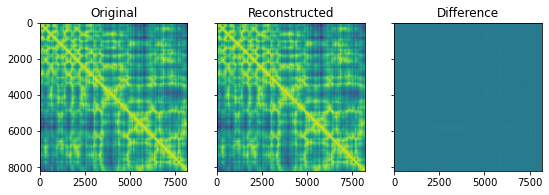

In [16]:
fig, ax = plt.subplots(1,3,figsize=(9, 3), sharey=True)
cmap = plt.get_cmap("viridis_r")

ax[0].set_title("Original")
ax[0].imshow(distogram, cmap="viridis_r")
ax[1].set_title("Reconstructed")
ax[1].imshow(new_distogram, cmap="viridis_r")
ax[2].set_title("Difference")
ax[2].imshow(delta_dist, cmap="viridis_r")


print("Diffs: max = {0} and min {1}".format(np.amax(delta_dist.numpy()),
                                            np.amin(delta_dist.numpy()) ))

In [17]:
# save pdb file and check manually here: 
# https://molstar.org/viewer/
buffer_save = mdtraj.load("data/1h22_protein.pdb")
buffer_save.xyz = pred_mod.T[None, :, :]
buffer_save.save("data/save_to_check.pdb")

In [18]:
# save pdb file and check manually here: 
# https://molstar.org/viewer/
buffer_save = mdtraj.load("data/1h22_protein.pdb")
buffer_save.xyz = prot_mod.T[None, :, :]
buffer_save.save("data/save_to_check_base.pdb")

Legend:
* blue/purple: reference
* green/orange: our reconstruction

Comments:
* **TODO:** see why smaller / considering resizing in kabsch

<img src="data/comparison.png"/>